### Classification on the Census Income Data Set

### Introduction

The goal here is to build a classification model to predict whether a person made above  or below $50,000 a year using the 1994 US census income data. The data include various demographic and socio-economic variables (e.g., age, race, sex, education, marital status, occupation, employment status, hours worked per week, etc), including each respondent's income level (<= 50,000 or > 50,000 USD) in 1994. 

### 1. Inspecting data and EDA

In [153]:
#import libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

#import the census data from the uci machine learning repository. 
file_link = 'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data'
column_names = ['age','workclass','fnlwgt','education','education-num','marital-status',
          'occupation','relationship','race','sex','capital-gain','capital-loss',
          'hours-per-week','native-country', 'income']

In [154]:
#read census csv file into a pandas dataframe and print its head.
df = pd.read_csv(file, index_col=False, header=None, names=column_names)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [155]:
#display the info of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
income            32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


#### Exploring the numerical variables

In [156]:
#see some summary statistics of the numerical variables
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Let's visualize each pair of numeric variables with seaborn pair grid. We can add histograms along the diagonal to show the univariate distribution of each numeric variable. Let's also specify income label as the hue argument. 

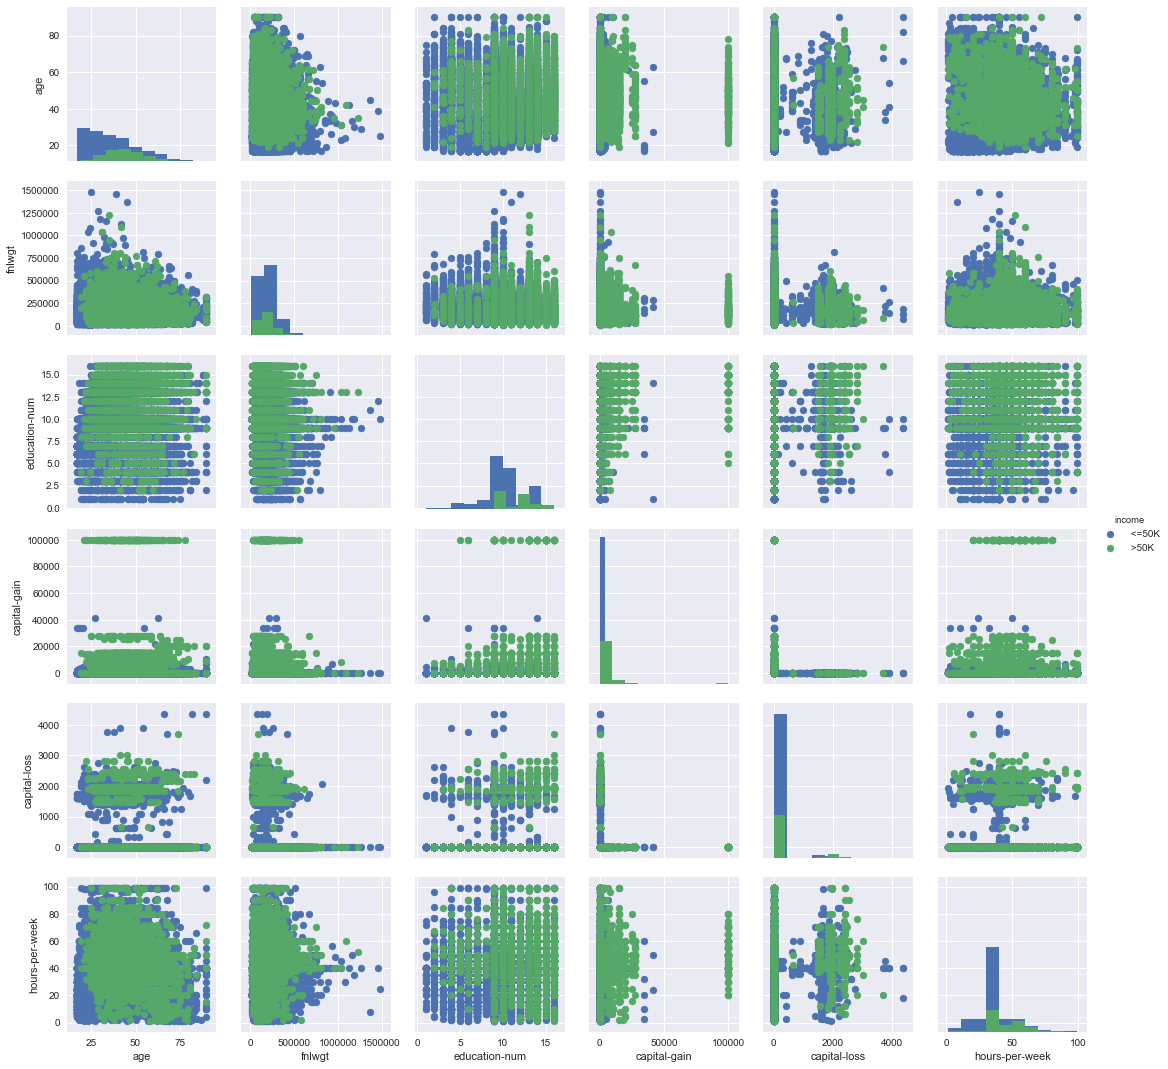

In [157]:
g = sns.PairGrid(df, hue='income')
_ = g.map_diag(plt.hist)
_ = g.map_offdiag(plt.scatter)
_ = g.add_legend()

There seems to be a lot more people who made 50K or less. People who had some college-level education, or higher, were much more likely to earn more than 50K. People who were less 20 years old were unlikely to make more than 50K. 


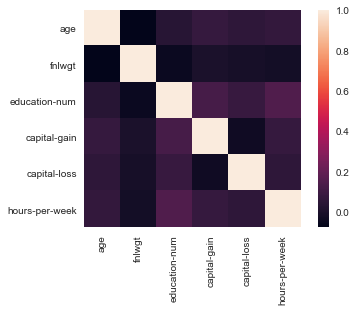

In [158]:
#let's also see a heat map version
_ = sns.heatmap(df.corr(), square=True)

#### Categorical Variables

Let's see what ordinal values in 'education-num' means. They should correspond to the values in the 'education' variable.

In [159]:
df.groupby(['education-num', 'education']).size()

education-num  education    
1               Preschool          51
2               1st-4th           168
3               5th-6th           333
4               7th-8th           646
5               9th               514
6               10th              933
7               11th             1175
8               12th              433
9               HS-grad         10501
10              Some-college     7291
11              Assoc-voc        1382
12              Assoc-acdm       1067
13              Bachelors        5355
14              Masters          1723
15              Prof-school       576
16              Doctorate         413
dtype: int64

What are the race and gender categories.

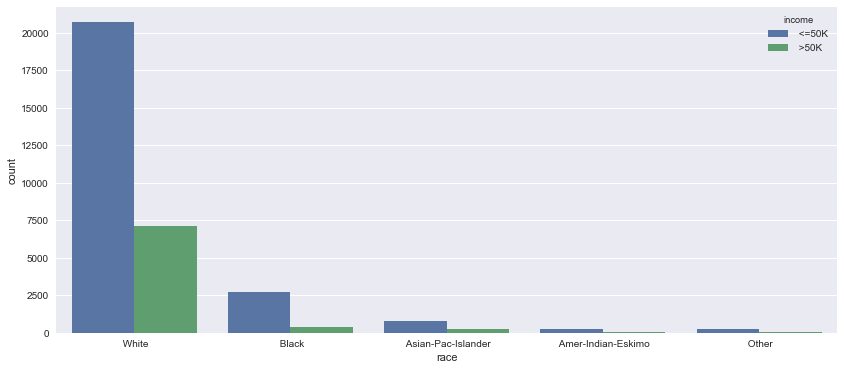

In [160]:
fig, ax = plt.subplots(1, figsize=(14,6))
_ =sns.countplot(x='race', hue='income', data=df, ax=ax)

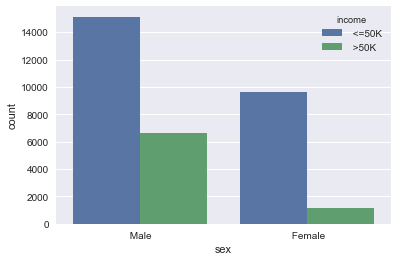

In [161]:
sns.countplot(x='sex', hue='income', data=df)

Let's see the visualize income label on age and education between the two genders.

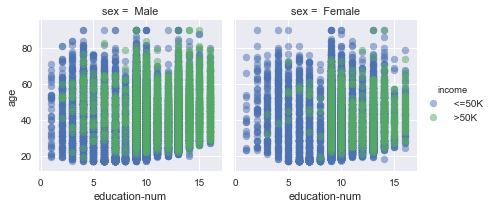

In [162]:
g = sns.FacetGrid(df, col="sex", hue="income")
_ = g.map(plt.scatter, "education-num", "age", alpha=.5)
_ = g.add_legend()

What if we stratify by race

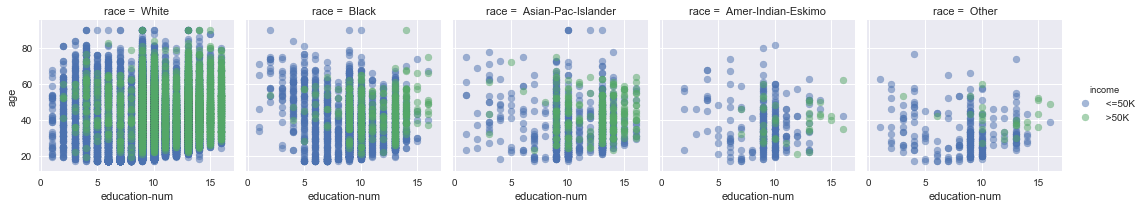

In [163]:
g = sns.FacetGrid(df, col="race", hue="income")
_ = g.map(plt.scatter, "education-num", "age",alpha=.5)
_ = g.add_legend()

### 2) Preprocessing data for classification

From the dataset description, unknown values were labeled with " ?"; There were over 2000 records in which workclass, occupation, and native country information were unknown. We will convert them to NaN and drop them for now since they aren't too many relative to the entire dataset, otherwise it may hurt our model's performance. 

In [164]:
df[df == ' ?'].count()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64

In [165]:
#convert '?' to nans and drop them from the dataframe. 
df[df == ' ?'] = np.nan
df = df.dropna()
df.shape

(30162, 15)

We need to standardize our numeric variables, such as age, education, hours-per-week, etc, all of which have different units. We can use scale from sklearn to standardize. 

In [179]:
from sklearn.preprocessing import scale
numeric_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
df[numeric_cols] = scale(df[numeric_cols])
df[numeric_cols].head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0.042796,-1.062722,1.128918,0.146092,-0.218586,-0.077734
1,0.880288,-1.007871,1.128918,-0.147445,-0.218586,-2.331531
2,-0.033340,0.244693,-0.439738,-0.147445,-0.218586,-0.077734
3,1.108695,0.425240,-1.224066,-0.147445,-0.218586,-0.077734
4,-0.794697,1.406658,1.128918,-0.147445,-0.218586,-0.077734


Next we would need to convert the categorical variables to numeric dummy variables, as sklearn estimators only take in numeric values. We can do this with pandas get_dummies method. 

In [182]:
#use pandas get_dummies method and set drop_first = True to drop the unneeded dummy variables. 
df_dummy = pd.get_dummies(df, drop_first=True)
df_dummy.head()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,...,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia,income_ >50K
0,0.042796,-1.062722,1.128918,0.146092,-0.218586,-0.077734,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.880288,-1.007871,1.128918,-0.147445,-0.218586,-2.331531,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,-0.033340,0.244693,-0.439738,-0.147445,-0.218586,-0.077734,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1.108695,0.425240,-1.224066,-0.147445,-0.218586,-0.077734,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,-0.794697,1.406658,1.128918,-0.147445,-0.218586,-0.077734,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we can split our numeric data into a features matrix X (with shape [n_samples, n_features]) and one-dimensional target array y (income). 

In [187]:
#split data into matrix X and vector y 
X = df_dummy.drop('income_ >50K', axis=1)
print(X.shape)
y = df_dummy['income_ >50K']
print(y.shape)

(30162, 96)
(30162,)


In [188]:
#split X and y into training and test sets, with a test size of 0.3 using sklearn's train_test_split 
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print("Shape of training and test sets")
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

Shape of training and test sets
(21113, 96) (21113,)
(9049, 96) (9049,)


### 3. Fitting two classification models

### Logistic Regression

In [190]:
#import Logostic regression and metrics 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

#create the classifier
logreg = LogisticRegression()

#fit the classifier to the training data
logreg.fit(X_train, y_train)

#predict the lables of the test set
y_pred = logreg.predict(X_test)

#compute and print confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6320  447]
 [ 901 1381]]
             precision    recall  f1-score   support

          0       0.88      0.93      0.90      6767
          1       0.76      0.61      0.67      2282

avg / total       0.85      0.85      0.85      9049



Plotting an ROC curve

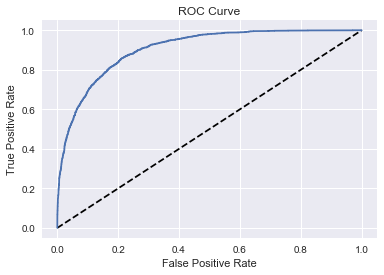

In [191]:
from sklearn.metrics import roc_curve

#Compute predicted probabilities with the 'predict_proba' method.
y_pred_prob = logreg.predict_proba(X_test)[:,1]

#generate ROC curve values (fpr, tpr, and thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### K-Nearest Neighbors

Let's now try the KNN classifier 

In [200]:
from sklearn.neighbors import KNeighborsClassifier

#create an instance of KNN classifier call knn without the default settings, where n_neighbors=5
knn = KNeighborsClassifier()

#fit classifier to training data
knn.fit(X_train, y_train)

#predict on test data
y_pred = knn.predict(X_test)

#print confusion matrix and classifcation report
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6109  658]
 [ 892 1390]]
             precision    recall  f1-score   support

          0       0.87      0.90      0.89      6767
          1       0.68      0.61      0.64      2282

avg / total       0.82      0.83      0.83      9049



It looks like the logistic regression did slightly better than the default KNN classifier. 

Let's see if we can tune the num_neighbors parameter to get better predictions. We will loop through 1-9 neighbors (this will take a few minutes to run)

In [204]:
# Setup vectors to store train and test accuracy
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the estimator to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

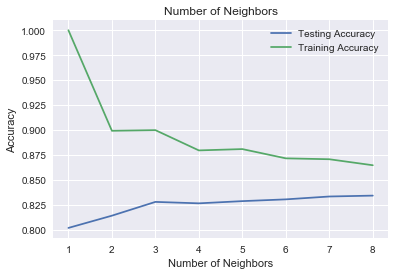

In [205]:
#Plot results
plt.title('Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()